<a href="https://colab.research.google.com/github/shantam-8/ML-Materials-Individual-Project/blob/main/Individual_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Individual Project

In [ ]:
import numpy as np

# Insert your values
Name = "Shantam Gilra" # Replace with your name
CID = 1878023 # Replace with your College ID (as a numeric value with no leading 0s)

# Set a random seed using the CID value
CID = int(CID)
np.random.seed(01878023)

# Print the message
print("This is the work of " + Name + " [CID: " + str(CID) + "]")

This is the work of Shantam Gilra [CID: 1878023]


## Problem statement

You have been assigned one dataset from the [list](https://matbench.materialsproject.org/Benchmark%20Info/matbench_v0.1/) on [MatBench](https://matbench.materialsproject.org). You should state what problem you are trying to solve and comment on the best-performing model in the benchmark.

## 1.0 Libraries Used

In [ ]:
training_mode = True

In [ ]:
# Installation of libraries
if training_mode == False:
  !pip install matminer=="0.9.0" --quiet
  !pip install pymatgen=="2023.09.25" --quiet

!pip install elementembeddings --quiet
!pip install xgboost --quiet
!pip install lightgbm --quiet

!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.7/807.7 kB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 24.3

In [ ]:
# Import of modules
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation with DataFrames
np.random.seed(1878023)


if training_mode == False:
  import matminer  # Materials informatics
  from matminer.datasets.dataset_retrieval import load_dataset  # Load materials datasets
  from pymatgen.core import Structure, Composition  # Materials analysis for crystal structures
from elementembeddings.core import Embedding


import plotly.express as px


# To make the model run faster
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2.0 Data Preparation



In [ ]:
if training_mode == False:
  df = load_dataset("matbench_expt_gap")
else:
  df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Main Data.csv")

df.head(10)

,composition,gap expt
0,Ag(AuS)2,0.00
1,Ag(W3Br7)2,0.00
2,Ag0.5Ge1Pb1.75S4,1.83
3,Ag0.5Ge1Pb1.75Se4,1.51
4,Ag2BBr,0.00
5,Ag2BiO3,0.00
6,Ag2GeS3,1.98
7,Ag2GeSe3,0.90
8,Ag2HgI4,2.47
9,Ag2Mo(I2O7)2,3.06


In order to correctly featurise the dataset given, different featurisers from Maminer and Element Embeddings were used. It was likely that different statistical elements (minimum, maximum, range, mean, avg_dev and mode) of different Magpie properties would be important to accurately predict the band gap. Hence, all statistical elements of all Magpie properties were added to the featurised dataset. This was followed by an addition to one-hot encoded columns of atomic structure and properties like the band center.

### 2.1 Data Featurisation

In [ ]:
if training_mode == False:

  # Featurising df
  from elementembeddings.composition import composition_featuriser, CompositionalEmbedding
  from matminer.featurizers.composition.composite import ElementProperty
  from matminer.featurizers.composition.element import BandCenter


  # Adding fractional composition column to main database.
  df['fractional_composition'] = df['composition'].apply(lambda x: Composition(x).fractional_composition)

  # Featurising based on magpie data using fractional composition.
  df_featurised = ElementProperty.from_preset(preset_name="magpie").featurize_dataframe(df, col_id='fractional_composition')

  # Featurising by adding one-hot collumns of each compound
  composition_df = composition_featuriser(df_featurised["composition"], embedding="atomic", stats=["sum"])
  df_featurised = pd.concat([df_featurised, composition_df], axis=1)

  # # Featurising by adding one-hot collumns of each compound
  # bandcenter_df = BandCenter().featurize_dataframe(df, col_id='fractional_composition', ignore_errors=True)
  # df_featurised = pd.concat([df_featurised, bandcenter_df], axis=1)

  # Adding column that includes number of atoms in each compound
  df_featurised["num_atoms"] = df["composition"].apply(lambda x: CompositionalEmbedding(x, "magpie").num_atoms)

  # Drop non-featurised columns
  df_featurised = df_featurised.drop(["composition", "gap expt", "fractional_composition", "formula"], axis=1)

else:
  df_featurised = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Featurised Data.csv")


df_featurised

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,sum_Ds,sum_Rg,sum_Cn,sum_Nh,sum_Fl,sum_Mc,sum_Lv,sum_Ts,sum_Og,num_atoms
0,16.0,79.0,63.0,47.400000,25.280000,16.0,65.0,88.0,23.0,74.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00
1,35.0,74.0,39.0,46.714286,15.619048,35.0,51.0,95.0,44.0,81.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.00
2,16.0,82.0,66.0,36.275862,23.552913,16.0,65.0,88.0,23.0,83.482759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.25
3,32.0,82.0,50.0,46.206897,17.388823,34.0,65.0,89.0,24.0,84.034483,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.25
4,5.0,47.0,42.0,33.500000,14.250000,47.0,65.0,95.0,30.0,74.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4599,7.0,73.0,66.0,26.800000,23.760000,7.0,44.0,82.0,38.0,67.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00
4600,40.0,52.0,12.0,46.000000,6.000000,40.0,44.0,90.0,46.0,67.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.00
4601,8.0,40.0,32.0,23.000000,8.500000,22.0,43.0,87.0,44.0,54.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.00
4602,9.0,40.0,31.0,14.500000,8.250000,9.0,43.0,93.0,50.0,80.625000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.00


It was not clear as to which features are important and training models with non-important features would increase computation costs and would decrease the model's accuracy. Hence, a preliminary Random Forest regressor was trained on the whole dataset to derive the feature importances of all features. This was represented in two different ways - a bar chart containing the feature importances of different features and a plot of one decision tree of the random forest ensemble.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Get an array of the target variable
y = df["gap expt"]

# Training a preliminary random forest regressor to understand the importance of different features
prelim_rf = RandomForestRegressor(random_state = 42, n_jobs = -1)
prelim_rf.fit(df_featurised, y)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [ ]:
# Load the atomic data
atomic_feature_labels = Embedding.load_data('atomic').feature_labels
one_hot_columns = ["sum_" + a for a in atomic_feature_labels]

# Get index of all one-hot encoded element columns to sum their feature importances
imp = prelim_rf.feature_importances_
feature_col = df_featurised.columns

elem_indices = [np.where(np.isin(df_featurised.columns, one_hot_columns))[0]]
elem_imp = imp[np.where(np.isin(df_featurised.columns, one_hot_columns))[0]].sum()

# Removing individual element contributions and adding them together
imp = np.delete(imp, elem_indices)
imp = np.append(imp, elem_imp)

# Removing individual element columns and adding "Elements"
feature_col = np.delete(feature_col, elem_indices)
feature_col = np.append(feature_col, "Elements")

# Sorting both arrays based on descending order of importances
sort_inds = imp.argsort()
imp = imp[sort_inds[::-1]]
feature_col = feature_col[sort_inds[::-1]]

# Plot the bar chart containing the feature importances of different features
fig = px.bar(x = feature_col, y = imp,
             labels={"x": "Preliminary Feature Columns", "y": "Feature Importances"},
             title="Feature Importance Bar Chart")

fig.update_xaxes(tickfont=dict(size = 6))
fig.show()

The chart signifies the importance of added features like the one-hot encoded atomic data and band center. As seen, all features after "MagpieData mode AtomicWeight" have very less importance values (<0.001) and would be removed.

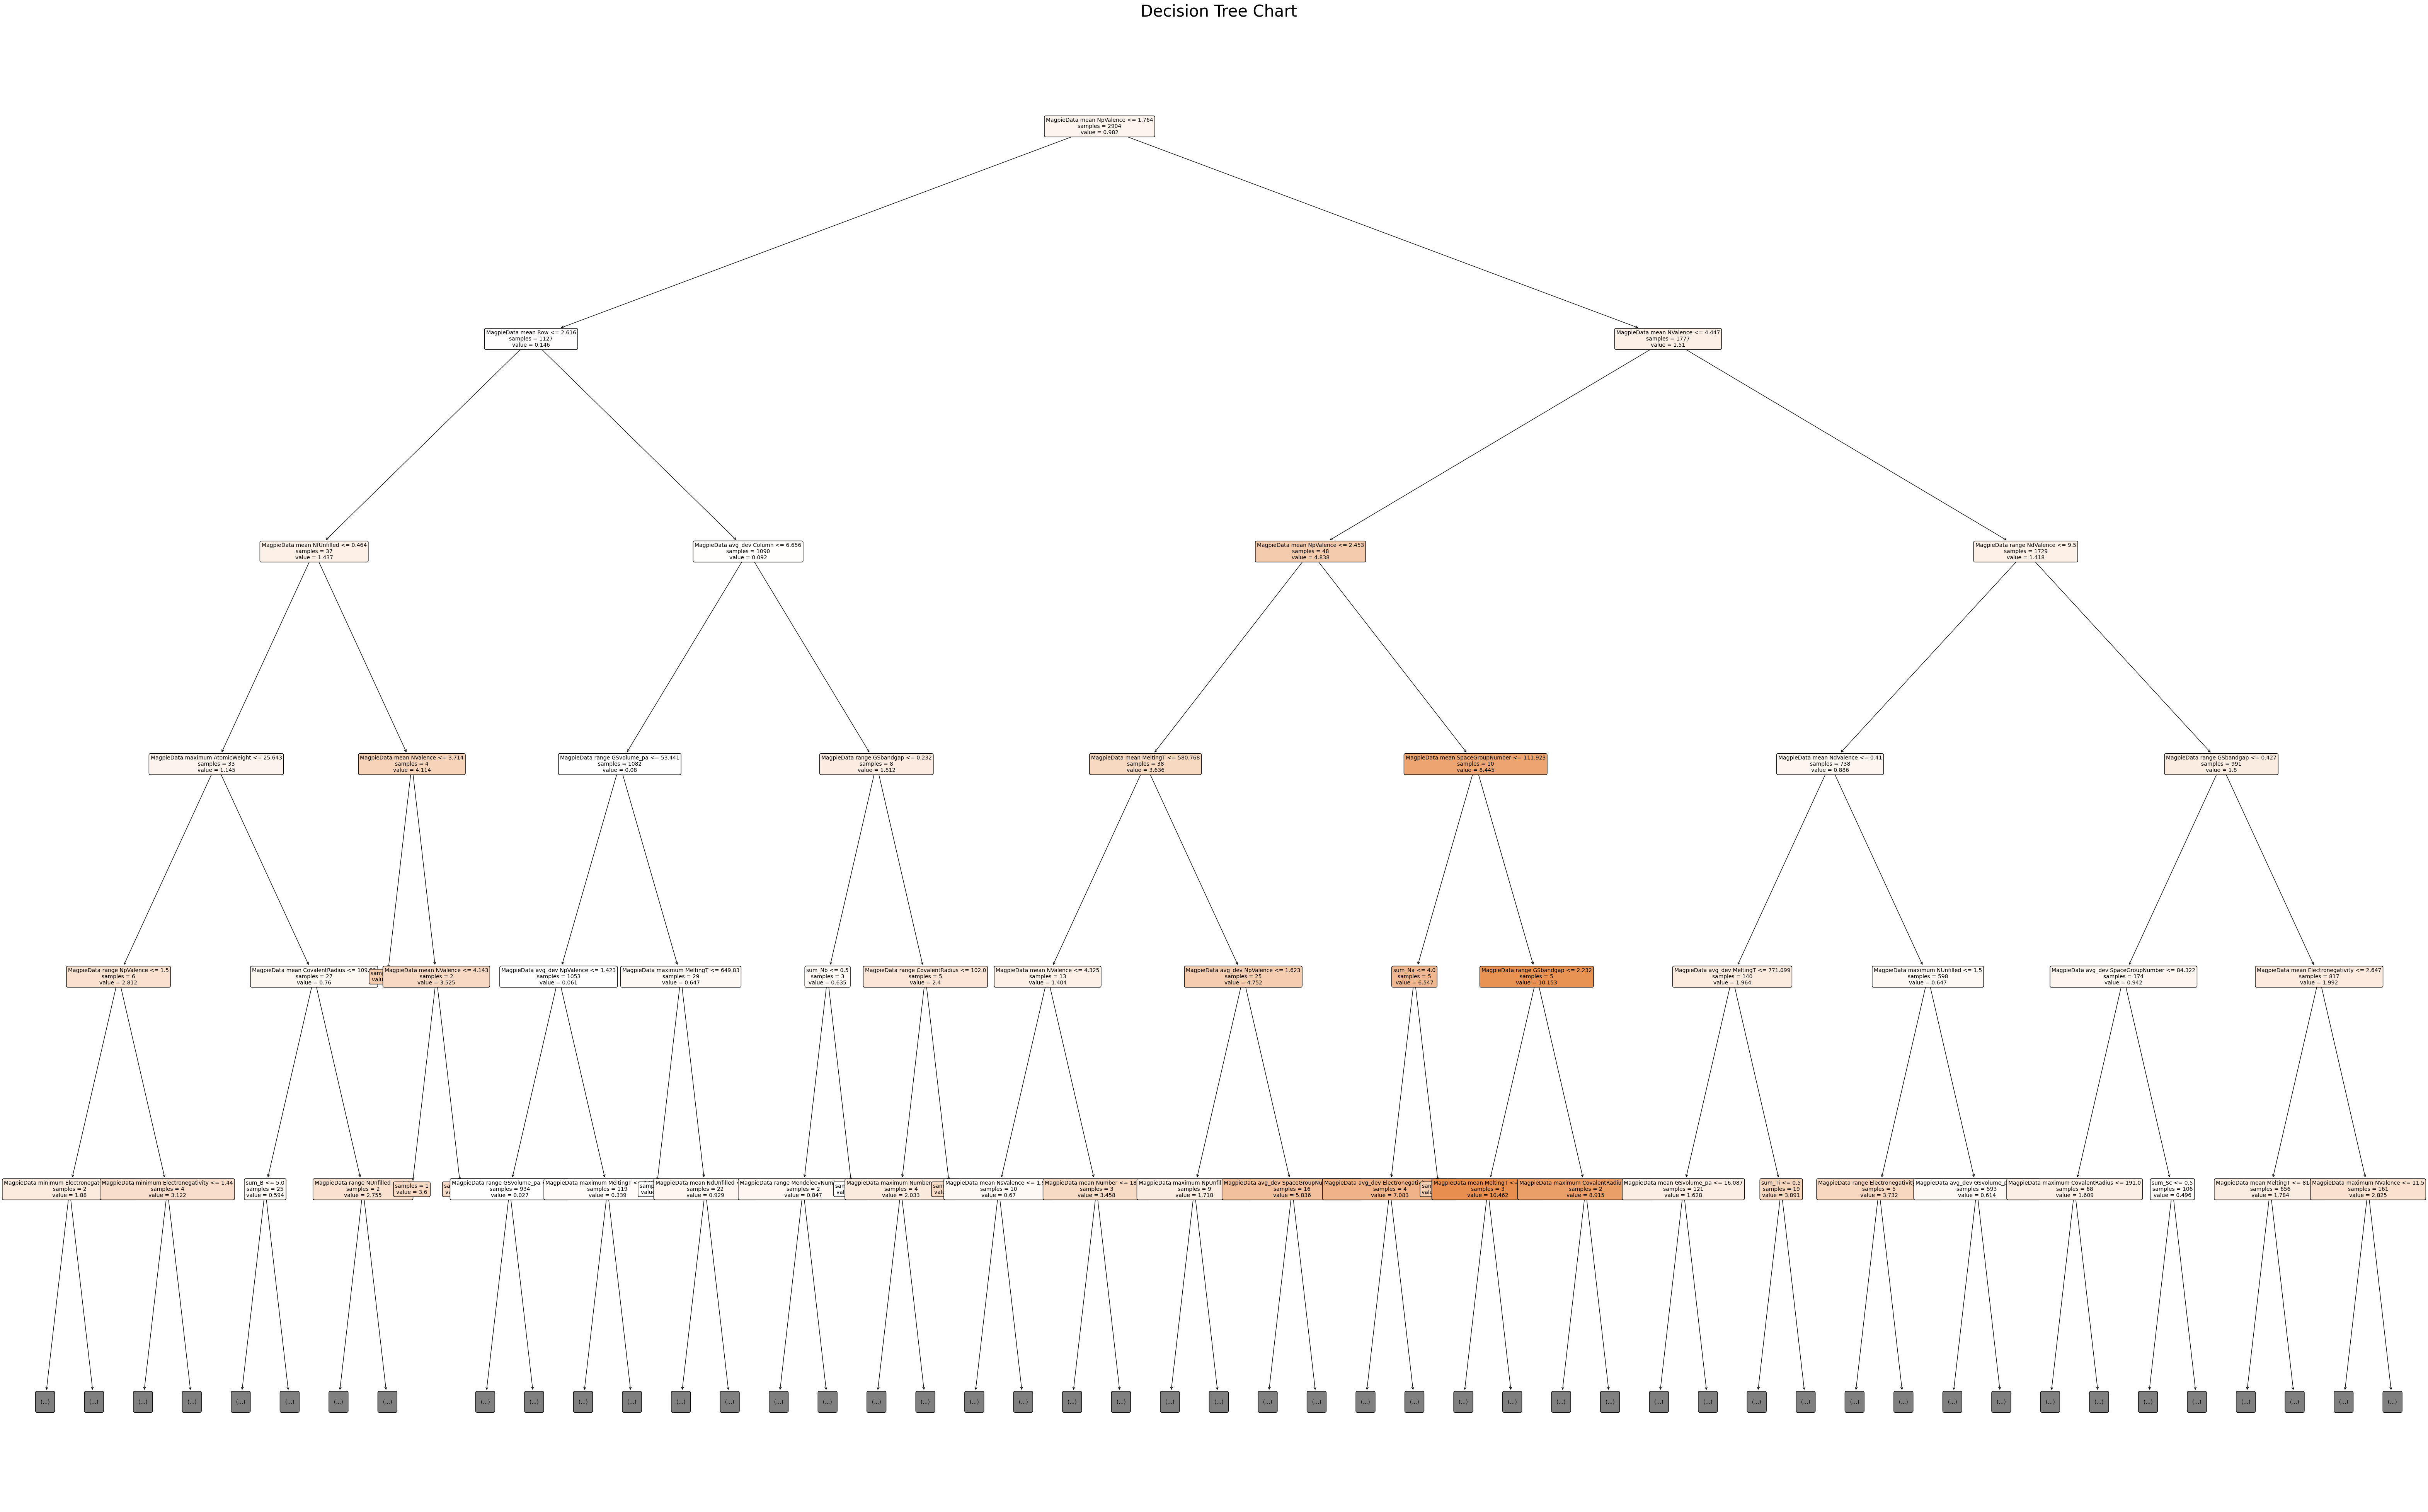

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt

# Plot a chart of one decision tree in the random forest ensemble (click on the graph to zoom it)
plt.figure(figsize=(80, 50))
_ = tree.plot_tree(prelim_rf.estimators_[0], max_depth = 5, feature_names = df_featurised.columns, filled = True, rounded = True, fontsize = 10, impurity = False)
plt.title("Decision Tree Chart", fontsize = 30)
plt.show()

While the chart further amplified the importance of "MagpieData mean NpValence", it also showed the high extremity (darker shades of the box depict higher extremity) of compositions specific properties. This indicates that the predicted values of some compositions would have high deviations from the actual values.

While these compositions could be filtered out of the training and testing datasets, these were still left in the dataset as it can be possible that other decision trees in the ensemble or other models can accurately predict the band gap.

In [ ]:
# Remove all column values in the featurised dataset with a lower feature importance than "MagpieData range GSmagmom"
X = df_featurised.drop(feature_col[np.where(feature_col == "MagpieData mode AtomicWeight")[0][0] + 1:], axis=1)

In [ ]:
X

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,sum_Ds,sum_Rg,sum_Cn,sum_Nh,sum_Fl,sum_Mc,sum_Lv,sum_Ts,sum_Og,num_atoms
0,16.0,79.0,63.0,47.400000,25.280000,16.0,65.0,88.0,23.0,74.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00
1,35.0,74.0,39.0,46.714286,15.619048,35.0,51.0,95.0,44.0,81.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.00
2,16.0,82.0,66.0,36.275862,23.552913,16.0,65.0,88.0,23.0,83.482759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.25
3,32.0,82.0,50.0,46.206897,17.388823,34.0,65.0,89.0,24.0,84.034483,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.25
4,5.0,47.0,42.0,33.500000,14.250000,47.0,65.0,95.0,30.0,74.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4599,7.0,73.0,66.0,26.800000,23.760000,7.0,44.0,82.0,38.0,67.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00
4600,40.0,52.0,12.0,46.000000,6.000000,40.0,44.0,90.0,46.0,67.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.00
4601,8.0,40.0,32.0,23.000000,8.500000,22.0,43.0,87.0,44.0,54.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.00
4602,9.0,40.0,31.0,14.500000,8.250000,9.0,43.0,93.0,50.0,80.625000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.00


The final dataset has 4604 compositions with 219 features.

### 2.2 Data Analysis

The distribution of band gap values was then explored in the context of the features by reducing the number of dimensions to three using PCA.

In [ ]:
from sklearn.decomposition import PCA

# Performing a 3 axes PCA on the featurised dataset
pca = PCA(n_components=3)
transformed_data = pca.fit_transform(X)

# Plotting 3D scatter plot
fig = px.scatter_3d (x = transformed_data[:, 0], y = transformed_data[:, 1], z = transformed_data[:, 2], color = df["gap expt"][X.index],
                     labels = {"x": "PCA X-axis", "y": "PCA Y-axis", "z": "PCA Z-axis", "color": "Band Gap"},
                     title = "PCA 3D Scatter Plot")

fig.update_layout(scene_camera = dict(eye = dict(x=0, y=0, z=1.5)))
fig.show()

The 3D Scatter plot is displayed on a specific camera angle to depict the relative postion of compositions having high and low band gaps - as seen, high band gaps are typically form a cluster in the left region. While the PCA did not have any information regarding the band gap, it was able to loosely seperate the high and low band gap compounds - hence, justifying the validity of the featurised dataset.

However, the 3D scatter plot also indicates the dominance of compositions with a low band gap. This distribution is further explored using a histogram.

In [146]:
# Plotting histogram of Band Gaps
fig = px.histogram(x = df["gap expt"],
                   nbins = 12,
                   marginal = "box",
                   labels = {"x": "Band Gap", "count" : "Count"},
                   title = "Distribution of Band Gaps")

fig.show()

Due to the comparatively high number of low band gaps as seen by the box plot and graph, the training and testing datasets can be split using a stratified split rather than a random split. This may ensure that the model will be more robust and accurate. However, to create preliminary models, a random split will be used.

## 3.0 Training and Testing

### 3.1 Baseline Models

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xg
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

from plotly.subplots import make_subplots
import plotly.graph_objects as go


# Standard scaling of featurised dataset for different models.
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

# Target Values
y = df["gap expt"]

# Splitting train and test values
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.2, random_state=42)

In [ ]:
def models_eval (models_dict: dict, cv: int = 5, show_graph: bool = False, cols: int = 3) -> pandas.Dataframe | plotly.graph_objects._figure.Figure:

  """
  DESCRIPTION
  Function to evaluate different models. Multiple models and their respective
  datasets are passed through as a dictionary and are trained and evaluated. Returns
  a DataFrame including metrics like -

  1) Cross Validation Root Mean Square Error (CV RMSE)
  2) Cross Validation Coefficient of Determination (CV R2)
  3) Mean of Cross Validation Mean Absolute Error values (CV MAE)
  4) Standard Deviation of Cross Validation Mean Absolute Error values (std MAE)
  5) Test Root Mean Square Error (Test RMSE)
  6) Test Coefficient of Determination (Test R2)
  7) Test  Mean Absolute Error values (Test MAE)
  8) Time taken to reach each model (Time)

  Also provides an option of plotting a graph between predicted target values and actual target values.


  KEYWORD ARGUMENTS
  models_dict (dict)  -- Dictionary in the format {"Model Name": [model, X_train, X_test, y_train, y_test]}
  cv (int)            -- Number of cross validation splits (default 5)
  show_graph (bool)   -- True to display graph, False to not display graph (default = False)
  cols (int)          -- Number of sub-plot columns in graph object (default = 3)


  OUTPUT
  metrics_df (pandas.DataFrame)             -- Dataframe including different metrics of different models
  fig (plotly.graph_objects._figure.Figure) -- Figure object comparing predicted target values with actual target values.

  """

  # Setting up DataFrame object to hold data
  metrics_df = pd.DataFrame(columns = ["Model Name","CV RMSE (eV)", "CV R2", "CV mean MAE", "CV std MAE", "Test RMSE (eV)", "Test R2", "Test MAE", "Time (s)"])

  # Initiating figure if show_graph = True
  if show_graph:
    cols = cols
    rows = len(models_dict) // cols + (1 if len(models_dict) % cols != 0 else 0)

    fig = make_subplots(rows = rows,
                      cols = cols,
                      subplot_titles = list(models_dict.keys()))

  # Loop to run different models
  for ind, m in enumerate(models_dict):

    model = models_dict[m][0]
    X_train = models_dict[m][1]
    X_test = models_dict[m][2]
    y_train = models_dict[m][3]
    y_test = models_dict[m][4]

    model.fit(X_train, y_train)

    cv_scores = cross_validate(model, X_train, y_train, cv = cv, scoring = ('r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'), n_jobs = -1)
    y_pred = model.predict(X_test)

    # Testing Metrics
    test_rmse = root_mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)
    test_mae = mean_absolute_error(y_test, y_pred)

    metrics_list = [m,
                    np.mean(abs(cv_scores["test_neg_root_mean_squared_error"])),
                    np.mean(abs(cv_scores["test_r2"])),
                    np.mean(abs(cv_scores["test_neg_mean_absolute_error"])),
                    np.std(abs(cv_scores["test_neg_mean_absolute_error"])),
                    test_rmse,
                    test_r2,
                    test_mae,
                    np.mean(cv_scores["fit_time"])]

    # Storing metrics in metrics_df
    metrics_df.loc[len(metrics_df)] = metrics_list

    # Displaying graph if show_graph = True
    if show_graph:
      fig.add_trace(
          go.Scatter(x = y_test, y = model.predict(X_test), mode="markers"),
          col = ind % cols + 1,
          row = int(str((ind/cols) + 1)[0]),
          )

      fig.add_trace(
        go.Scatter(x = y_test, y = y_test, mode = "lines", line = dict(color = "black"), hoverinfo = "none"),
        col = ind % cols + 1,
        row = int(str((ind/cols) + 1)[0])
        )

      fig.update_xaxes(title_text="Actual Values", col = ind % cols + 1, row = int(str((ind/cols) + 1)[0]))
      fig.update_yaxes(title_text="Predicted Values", col = ind % cols + 1, row = int(str((ind/cols) + 1)[0]))


  if show_graph:
    fig.update_layout(height = 500 * rows, width = 500 * cols, showlegend = False, title_text="Model Evaluation")
    fig.show()

  return metrics_df

Based on a paper by Wang et al, different models have been considered as baseline models. The baseline models include linear regression models like Kernal Ridge, non-linear regression models like Support Vector Machine and K-Nearest Neighbors and ensemble models like Random Forest Regressor, Gradient Boost Regressor, XG Boost and Light Gradient Boosting Machine (LGBM). This is done to ensure that wide variety of model architecture can be compared against the data.

While XG Boost and LGBM are forms of Gradient Boost Regressor, all three have been considered to ensure a more robust comparison between different models. However, due to their more optimised frameworks, it can be hypothesised that XG Boost and LGBM would have better metrics than Gradient Boost Regressor.

In [ ]:
models_dict = {
    "Random Forest Regressor" : [RandomForestRegressor(n_jobs = -1), X_train, X_test, y_train, y_test],
    "Support Vector Machine Regressor" : [SVR(), X_train, X_test, y_train, y_test],
    "XG Boost" : [xg.XGBRegressor(n_jobs = -1), X_train, X_test, y_train, y_test],
    "Kernal Ridge" : [KernelRidge(), X_train, X_test, y_train, y_test],
    "KNN Regressor" : [KNeighborsRegressor(n_jobs = -1), X_train, X_test, y_train, y_test],
    "LGBM Regressor" : [LGBMRegressor(n_jobs = -1, verbose = -1), X_train, X_test, y_train, y_test],
    "Gradient Boost Regressor" : [GradientBoostingRegressor(), X_train, X_test, y_train, y_test]
}

models_eval(models_dict, show_graph = True, cv = 5)

,Model Name,CV RMSE (eV),CV R2,CV mean MAE,CV std MAE,Test RMSE (eV),Test R2,Test MAE,Time (s)
0,Random Forest Regressor,0.828834,0.667239,0.457586,0.015864,0.855855,0.659427,0.444309,30.551801
1,Support Vector Machine Regressor,1.089549,0.425514,0.593041,0.011870,1.069238,0.468432,0.604475,1.257106
2,XG Boost,0.808240,0.684075,0.456016,0.006986,0.776798,0.719440,0.440464,2.777316
3,Kernal Ridge,1.083857,0.431346,0.745993,0.019018,1.115659,0.421273,0.769046,0.889668
4,KNN Regressor,0.972687,0.542343,0.536913,0.017311,1.022558,0.513832,0.539153,0.004309
5,LGBM Regressor,0.803648,0.687494,0.447287,0.010320,0.789822,0.709953,0.435510,11.201668
6,Gradient Boost Regressor,0.871945,0.632084,0.543131,0.010787,0.905070,0.619132,0.550948,9.783835


As seen by the above graphs and table, architecture of linear regression models like Kernal Ridge would not be suitable. Furthermore, the graphs indicate that all models are not able to predict Band Gap energy when its too high. This might be becuase there is not enough high Band Gap materials in the training set. In order to ensure this, a stratified split will be explored and compared with the normal split.

While hypertuning and evaluating different models, Root Mean Sqaure Error (RMSE) will be be given priority. This is done as RMSE particularly gives a high weight to large errors, ensuring that the models developed would be able to effectively reduce the error between the actual values and predicted values.  

### 3.2 Data Stratification

As mentioned in Section 2.2, the band gap data has an uneven distribution of data where most values tend to be closer to 0. Hence, data stratification is considered where clusters are decided by a KMeans clustering algorithm to enable stratification. This algorithm was particularly chosen as it allows a direct control in the number of clusters made - too less `(n_clusters = ~1)` or too more clusters `(n_clusters = ~10)` would make stratification obsolete.

Hence, to understand the ideal value for `n_clusters`, a loop was run to generate upto 10 clusters and understand its effect on the metrics of different models. In this case, `n_clusters = 1` creates benchmark models as no stratification happens. A `random_state` parameter was also set in `train_test_split` to ensure equal comparison between models created.

In [128]:
from sklearn.cluster import KMeans

if training_mode == True:
  strat_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/strat_df.csv")

else:
  strat_df = pd.DataFrame()

  for i in range(9):
    # Trying different clusters
    kmean_cluster = KMeans(n_clusters = i + 1).fit(pd.DataFrame(y))

    # Splitting train and test values
    strat_X_train, strat_X_test, strat_y_train, strat_y_test = train_test_split(scaled_X, y, test_size = 0.2, random_state = 42, stratify = kmean_cluster.labels_)

    # Training all models
    models_dict = {
      "Random Forest Regressor" : [RandomForestRegressor(n_jobs = -1), strat_X_train, strat_X_test, strat_y_train, strat_y_test],
      "Support Vector Machine Regressor" : [SVR(), strat_X_train, strat_X_test, strat_y_train, strat_y_test],
      "KNN Regressor" : [KNeighborsRegressor(n_jobs = -1), strat_X_train, strat_X_test, strat_y_train, strat_y_test],
      "LGBM Regressor" : [LGBMRegressor(n_jobs = -1, verbose = -1), strat_X_train, strat_X_test, strat_y_train, strat_y_test],
      "XG Boost" : [xg.XGBRegressor(n_jobs = -1), strat_X_train, strat_X_test, strat_y_train, strat_y_test],
      "Gradient Boost Regressor" : [GradientBoostingRegressor(), strat_X_train, strat_X_test, strat_y_train, strat_y_test]
      }

    metrics_df = models_eval(models_dict, cv = 10, show_graph = False)
    metrics_df["Stratify"] = i + 1

    strat_df = pd.concat([strat_df, metrics_df])

strat_df

,Model Name,CV RMSE (eV),CV R2,CV mean MAE,CV std MAE,Test RMSE (eV),Test R2,Test MAE,Time (s),Stratify
0,Random Forest Regressor,0.806877,0.685898,0.442739,0.033275,0.790003,0.686325,0.428459,36.750764,1
1,Support Vector Machine Regressor,1.097145,0.426853,0.598630,0.049286,0.994434,0.502980,0.547055,1.969962,1
2,KNN Regressor,0.960003,0.556319,0.522393,0.037978,0.972352,0.524808,0.508026,0.004941,1
3,LGBM Regressor,0.800962,0.691896,0.440956,0.029960,0.729194,0.732756,0.404930,12.572908,1
4,XG Boost,0.806735,0.686366,0.445250,0.024061,0.771574,0.700789,0.427521,2.699897,1
5,Gradient Boost Regressor,0.873976,0.632151,0.545678,0.039197,0.848630,0.638041,0.520092,10.679747,1
0,Random Forest Regressor,0.833431,0.659335,0.448813,0.032133,0.806907,0.703534,0.442469,36.971721,2
1,Support Vector Machine Regressor,1.053405,0.460023,0.576752,0.043175,1.170243,0.376436,0.636272,2.037941,2
2,KNN Regressor,0.977676,0.530953,0.528835,0.035561,0.974156,0.567899,0.527403,0.006023,2
3,LGBM Regressor,0.814180,0.675187,0.442678,0.021416,0.778458,0.724070,0.432126,13.156459,2


In [129]:
# strat_df.to_csv("/content/drive/MyDrive/Colab Notebooks/strat_df.csv", index = None)

In [133]:
## Plotting RMSE values
fig = px.line(strat_df, x = "Stratify", y = ["CV RMSE (eV)", "Test RMSE (eV)"], color="Model Name", markers=True)

# Changing line types
for i, trace in enumerate(fig.data):
  if i % 2 == 1:
    trace.line.dash = "dash"

# Create traces for custom legend (solid and dash lines)
solid_trace = go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='black', width=2, dash='dash'), name = "Test RMSE (eV)")
dash_trace = go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='black', width=2), name = "CV RMSE (eV)")
fig.add_trace(solid_trace)
fig.add_trace(dash_trace)

# Updating axis and title texts
fig.update_xaxes(title_text = "Number of Stratification Clusters")
fig.update_yaxes(title_text = "RMSE Values")
fig.update_layout(title_text="RMSE Comparison")

fig.show()


## Plotting MAE values
fig = px.line(strat_df, x = "Stratify", y = ["CV mean MAE", "Test MAE"], color="Model Name", markers=True)

# Changing line types
for i, trace in enumerate(fig.data):
  if i % 2 == 1:
    trace.line.dash = "dash"

# Create traces for custom legend (solid and dash lines)
solid_trace = go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='black', width=2, dash='dash'), name = "Test MAE")
dash_trace = go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='black', width=2), name = "CV MAE")
fig.add_trace(solid_trace)
fig.add_trace(dash_trace)

# Updating axis and title texts
fig.update_xaxes(title_text = "Number of Stratification Clusters")
fig.update_yaxes(title_text = "MAE Values")
fig.update_layout(title_text="MAE Comparison")

fig.show()


## Plotting R2 values
fig = px.line(strat_df, x = "Stratify", y = ["CV R2", "Test R2"], color="Model Name", markers=True)

# Changing line types
for i, trace in enumerate(fig.data):
  if i % 2 == 1:
    trace.line.dash = "dash"

# Create traces for custom legend (solid and dash lines)
solid_trace = go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='black', width=2, dash='dash'), name = "Test R2")
dash_trace = go.Scatter(x=[None], y=[None], mode='lines', line=dict(color='black', width=2), name = "CV R2")
fig.add_trace(solid_trace)
fig.add_trace(dash_trace)

# Updating axis and title texts
fig.update_xaxes(title_text = "Number of Stratification Clusters")
fig.update_yaxes(title_text = "R2 Values")
fig.update_layout(title_text="R2 Comparison")
fig.show()

While it was predicted that `n_clusters = 3` would be the most suitable as materials could be clustered into metals, semiconductors and non-metals, the above analysis indicates that the testing metrics (RMSE and MAE) of most models are lower that others when `n_clusters` are either 1, 5, or 9. However, it is only at `n_clusters = 5` where the training error also slighlty decreases - ensuring it to be closer to the test error and reducing the generalisation gap. This indicates that the model would neither overfit nor underfit and would be able to accurately idenitify the band gaps of unknown compounds.

In [134]:
# Redfining train and test datasets
kmean_cluster = KMeans(n_clusters = 5).fit(pd.DataFrame(y))
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.2, random_state = 42, stratify = kmean_cluster.labels_)

In [ ]:
import plotly.graph_objects as go

# Plotting boxplots of Stratified Datasets
fig = go.Figure()

fig.add_trace(go.Box(y = y_train, name = "Training Dataset"))
fig.add_trace(go.Box(y = y_test, name = "Testing Dataset" ))

fig.update_yaxes(title_text = "Band Gap (eV)")
fig.update_layout(title_text = "Dataset Distribution")

fig.show()

As seen by the chart, Training and Testing datasets have a much more equal distribution - ensuring all models will be better trained.

### 3.3 Hyperparameter Tuning

Using the above training and testing datasets, the above models would be hypertuned and then compared against each other. In order to hypertune parameters, `optuna`, an optimization software framework was implemented instead of libraries like `skyopt` and `hyperopt` and `sklearn` in-built functions like `GridSearchCV` because of the following reasons -

1. `GridSearchCV` searches through a set of individual hyperparameters to find the best combination of parameters for a model, making it computationally expensive and time-consuming when there is a large set of hyperparameters.
On the other hand, libraries like `optuna`, `skyopt` and `hyperopt` creates a probablistic model of the search space and utilises Bayesian-based optimisation algorithms to determine the correct features, making it more robust and faster.

2. `optuna` and `hyperopt` use Tree of Parzen Estimators (TPE), unlike `skyopt`. TPE, being a type of Bayesian Optimisation, models the objective functions using a good and bad probability distributions and iteratively modifies them to determine the hyperparamters that lead to the lowest loss values. This algorithm has performed better than conventional Bayesian Optimisation algorithms, especially for large feature spaces.

3. `optuna` had added advantages of `pruning` and `direction`. While `pruning` reduces the likelihood of the objective to fall into local minimas, `direction` gave the option of minimising values instead of only maximising them.

For all models, feature spaces were iteratively narrrowed down after running multiple trials. An `objective` function was determined for each model which included different hyperparameters for the same. The
`study` ran different `trials` to optimise different hyperparameters and minimized the mean train RMSE values after cross validating the model three times.  



#### Trial

In [85]:
!pip install optuna
!pip install scikit-learn --upgrade


from numpy import genfromtxt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xg
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.neural_network import MLPRegressor

from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.model_selection import cross_val_score

import optuna
import logging
import sys

import pandas as pd

In [86]:
import numpy as np

np.random.seed(1878023)

In [87]:
from numpy import genfromtxt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xg
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.neural_network import MLPRegressor

from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.model_selection import cross_val_score

import optuna
import logging
import sys

import pandas as pd



# To make the model run faster
from google.colab import drive
drive.mount('/content/drive')

X_train = genfromtxt('/content/drive/MyDrive/Colab Notebooks/X_train.csv', delimiter=',')
X_test = genfromtxt('/content/drive/MyDrive/Colab Notebooks/X_test.csv', delimiter=',')
y_train = genfromtxt('/content/drive/MyDrive/Colab Notebooks/y_train.csv', delimiter=',')
y_test = genfromtxt('/content/drive/MyDrive/Colab Notebooks/y_test.csv', delimiter=',')


def models_eval (models_dict, cv = 5, show_graph = False, cols = 3):

  # Setting up DataFrame object to hold data
  metrics_df = pd.DataFrame(columns = ["Model Name","CV RMSE (eV)", "CV R2", "CV mean MAE", "CV std MAE", "Test RMSE (eV)", "Test R2", "Test MAE", "Time (s)"])

  # Initiating figure if show_graph = True
  if show_graph:
    cols = cols
    rows = len(models_dict) // cols + (1 if len(models_dict) % cols != 0 else 0)

    fig = make_subplots(rows = rows,
                      cols = cols,
                      subplot_titles = list(models_dict.keys()))

  # Loop to run different models
  for ind, m in enumerate(models_dict):

    model = models_dict[m][0]
    X_train = models_dict[m][1]
    X_test = models_dict[m][2]
    y_train = models_dict[m][3]
    y_test = models_dict[m][4]

    model.fit(X_train, y_train)

    cv_scores = cross_validate(model, X_train, y_train, cv = cv, scoring = ('r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'), n_jobs = -1)
    y_pred = model.predict(X_test)

    # Testing Metrics
    test_rmse = root_mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)
    test_mae = mean_absolute_error(y_test, y_pred)

    metrics_list = [m,
                    np.mean(abs(cv_scores["test_neg_root_mean_squared_error"])),
                    np.mean(abs(cv_scores["test_r2"])),
                    np.mean(abs(cv_scores["test_neg_mean_absolute_error"])),
                    np.std(abs(cv_scores["test_neg_mean_absolute_error"])),
                    test_rmse,
                    test_r2,
                    test_mae,
                    np.mean(cv_scores["fit_time"])]

    # Storing metrics in metrics_df
    metrics_df.loc[len(metrics_df)] = metrics_list

    # Displaying graph if show_graph = True
    if show_graph:
      fig.add_trace(
          go.Scatter(x = y_test, y = model.predict(X_test), mode="markers"),
          col = ind % cols + 1,
          row = int(str((ind/cols) + 1)[0]),
          )

      fig.add_trace(
        go.Scatter(x = y_test, y = y_test, mode = "lines", line = dict(color = "black"), hoverinfo = "none"),
        col = ind % cols + 1,
        row = int(str((ind/cols) + 1)[0])
        )

      fig.update_xaxes(title_text="Actual Values", col = ind % cols + 1, row = int(str((ind/cols) + 1)[0]))
      fig.update_yaxes(title_text="Predicted Values", col = ind % cols + 1, row = int(str((ind/cols) + 1)[0]))


  if show_graph:
    fig.update_layout(height = 500 * rows, width = 500 * cols, showlegend = False, title_text="Model Evaluation")
    fig.show()

  return metrics_df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 3.3.1 Support Vector Regressor

In [136]:
# Define an objective function to be maximized
def svr_objective(trial):

    # Suggest values for the hyperparameters using a trial object
    svc_c = trial.suggest_float('C', 92, 93, log=True)
    svc_gamma = trial.suggest_categorical('gamma', ["scale"])
    svc_epsilon = trial.suggest_float('epsilon', 0.11, 0.16)

    model = SVR(C = svc_c,
                gamma = svc_gamma,
                epsilon = svc_epsilon)
    model.fit(X_train, y_train)

    # Calculate the metric
    cv_scores = cross_validate(model, X_train, y_train, cv = 3, scoring = ('neg_root_mean_squared_error'), n_jobs = -1)
    score = np.mean(abs(cv_scores["test_score"]))

    # Set up pruning
    if trial.should_prune():
      raise optuna.TrialPruned()

    return score


# Create a study object and optimize the objective function
svr_study = optuna.create_study(
    direction = "minimize",
    pruner = optuna.pruners.HyperbandPruner()
)

svr_study.optimize(svr_objective, n_trials = 50)

[I 2024-03-09 00:00:03,451] A new study created in memory with name: no-name-b2af888d-1a3e-463f-9354-9c7f9b9d5a13
[I 2024-03-09 00:00:18,962] Trial 0 finished with value: 0.9593881547559588 and parameters: {'C': 92.17805770984097, 'gamma': 'scale', 'epsilon': 0.1439767453576627}. Best is trial 0 with value: 0.9593881547559588.
[I 2024-03-09 00:00:31,488] Trial 1 finished with value: 0.9596672837564532 and parameters: {'C': 92.9199048022788, 'gamma': 'scale', 'epsilon': 0.1559134744916286}. Best is trial 0 with value: 0.9593881547559588.
[I 2024-03-09 00:00:45,637] Trial 2 finished with value: 0.9591921133406753 and parameters: {'C': 92.23974824994123, 'gamma': 'scale', 'epsilon': 0.13176286455273856}. Best is trial 2 with value: 0.9591921133406753.
[I 2024-03-09 00:00:59,927] Trial 3 finished with value: 0.9590412904329989 and parameters: {'C': 92.47970275401744, 'gamma': 'scale', 'epsilon': 0.11372120559980667}. Best is trial 3 with value: 0.9590412904329989.
[I 2024-03-09 00:01:12,61

In [137]:
# Best SVR model chosen after hypertuning
best_svr = {'C': 92.47568939945727, 'gamma': 'scale', 'epsilon': 0.11009785495419731}

In [138]:
# Comparison with non-hypertuned model
models_dict = {
    "Support Vector Machine" : [SVR(), X_train, X_test, y_train, y_test],
    "SVM Hypertuned" : [SVR(**best_svr), X_train, X_test, y_train, y_test]
    }

models_eval(models_dict, cv = 5, show_graph = True, cols = 2)

,Model Name,CV RMSE (eV),CV R2,CV mean MAE,CV std MAE,Test RMSE (eV),Test R2,Test MAE,Time (s)
0,Support Vector Machine,1.092120,0.417788,0.600152,0.027851,1.105454,0.450165,0.588256,1.269825
1,SVM Hypertuned,0.933109,0.571821,0.551959,0.031188,0.816806,0.699815,0.480249,7.398682


#### 3.3.2 Random Forest Regressor

In [139]:
# Define an objective function to be maximized
def rf_objective(trial):

  # Suggest values for the hyperparameters using a trial object
  rf_max_depth = trial.suggest_int('max_depth', 210, 225)
  rf_max_features = trial.suggest_int('max_features', 47, 53)
  rf_min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 2)
  rf_n_estimators = trial.suggest_int('n_estimators', 345, 355)

  model = RandomForestRegressor(n_jobs = -1,
                                max_depth = rf_max_depth,
                                max_features = rf_max_features,
                                min_samples_leaf = rf_min_samples_leaf,
                                n_estimators = rf_n_estimators
                                )

  model.fit(X_train, y_train)

  # Calculate the metric
  cv_scores = cross_validate(model, X_train, y_train, cv = 3, scoring = ('neg_root_mean_squared_error'), n_jobs = -1)
  score = np.mean(abs(cv_scores["test_score"]))

  # Set up pruning
  if trial.should_prune():
    raise optuna.TrialPruned()

  return score


# Create a study object and optimize the objective function
rf_study = optuna.create_study(
    direction = "minimize",
    pruner = optuna.pruners.HyperbandPruner()
)

rf_study.optimize(rf_objective, n_trials = 50)

[I 2024-03-09 00:19:38,354] A new study created in memory with name: no-name-5c40f5b3-7ce7-433f-a939-807063d8a076
[I 2024-03-09 00:20:39,711] Trial 0 finished with value: 0.8515810352751988 and parameters: {'max_depth': 221, 'max_features': 51, 'min_samples_leaf': 1, 'n_estimators': 355}. Best is trial 0 with value: 0.8515810352751988.
[I 2024-03-09 00:21:28,037] Trial 1 finished with value: 0.8610169200871293 and parameters: {'max_depth': 219, 'max_features': 49, 'min_samples_leaf': 2, 'n_estimators': 350}. Best is trial 0 with value: 0.8515810352751988.
[I 2024-03-09 00:22:26,201] Trial 2 finished with value: 0.8541031497728963 and parameters: {'max_depth': 223, 'max_features': 47, 'min_samples_leaf': 1, 'n_estimators': 346}. Best is trial 0 with value: 0.8515810352751988.
[I 2024-03-09 00:23:12,967] Trial 3 finished with value: 0.8609392526893599 and parameters: {'max_depth': 216, 'max_features': 51, 'min_samples_leaf': 2, 'n_estimators': 354}. Best is trial 0 with value: 0.85158103

KeyboardInterrupt: 

In [140]:
# Best Random Forest model chosen after hypertuning
best_rf = {'max_depth': 217, 'max_features': 52, 'min_samples_leaf': 1, 'n_estimators': 348}

In [141]:
# Comparison with non-hypertuned model
models_dict = {
    "RF" : [RandomForestRegressor(n_jobs = -1), X_train, X_test, y_train, y_test],
    "RF Hypertuned" : [RandomForestRegressor(n_jobs = -1, **best_rf), X_train, X_test, y_train, y_test]
    }

models_eval(models_dict, cv = 5, show_graph = True, cols = 2)

,Model Name,CV RMSE (eV),CV R2,CV mean MAE,CV std MAE,Test RMSE (eV),Test R2,Test MAE,Time (s)
0,RF,0.859075,0.637361,0.466445,0.025241,0.772474,0.731515,0.430432,36.343362
1,RF Hypertuned,0.824819,0.665352,0.460509,0.025422,0.759342,0.740567,0.428396,23.963155


#### 3.3.3 XG Boost Regressor

In [142]:
# Define an objective function to be minimized
def xg_objective(trial):

  # Suggest values for the hyperparameters using a trial object
  xg_eta = trial.suggest_float('eta', 0.1, 0.1001, log = True)
  xg_booster = trial.suggest_categorical('booster', ["gbtree"])
  xg_min_child_weight = trial.suggest_float("min_child_weight", 4, 5)
  xg_n_estimators = trial.suggest_int("n_estimators", 150, 160)
  xg_grow_policy = trial.suggest_categorical('grow_policy', ["depthwise", "lossguide"])
  xg_max_leaves = trial.suggest_int("max_leaves", 65, 68)
  xg_max_depth = trial.suggest_int("max_depth", 0, 6)

  model = xg.XGBRegressor(n_jobs = -1,
                          verbosity = 0,
                          booster = xg_booster,
                          eta = xg_eta,
                          max_leaves = xg_max_leaves,
                          min_child_weight = xg_min_child_weight,
                          n_estimators = xg_n_estimators,
                          grow_policy = xg_grow_policy,
                          max_depth = xg_max_depth
                          )

  # Calculate the metric
  model.fit(X_train, y_train)

  cv_scores = cross_validate(model, X_train, y_train, cv = 3, scoring = ('neg_root_mean_squared_error'), n_jobs = -1)
  score = np.mean(abs(cv_scores["test_score"]))

  # Set up pruning
  if trial.should_prune():
    raise optuna.TrialPruned()

  return score


# Create a study object and optimize the objective function
xg_study = optuna.create_study(
    direction = "minimize",
    pruner = optuna.pruners.HyperbandPruner()
)

xg_study.optimize(xg_objective, n_trials = 30)

[I 2024-03-09 00:50:02,042] A new study created in memory with name: no-name-313d7330-4280-484d-86d9-8985f53624a8
[I 2024-03-09 00:50:19,246] Trial 0 finished with value: 0.8351936358794046 and parameters: {'eta': 0.10001449446549514, 'booster': 'gbtree', 'min_child_weight': 4.396508833060747, 'n_estimators': 157, 'grow_policy': 'depthwise', 'max_leaves': 68, 'max_depth': 0}. Best is trial 0 with value: 0.8351936358794046.
[I 2024-03-09 00:50:22,296] Trial 1 finished with value: 0.872933772525061 and parameters: {'eta': 0.10003303295528031, 'booster': 'gbtree', 'min_child_weight': 4.578916814879378, 'n_estimators': 151, 'grow_policy': 'lossguide', 'max_leaves': 67, 'max_depth': 4}. Best is trial 0 with value: 0.8351936358794046.
[I 2024-03-09 00:50:23,789] Trial 2 finished with value: 0.9459744192595023 and parameters: {'eta': 0.10006386635688991, 'booster': 'gbtree', 'min_child_weight': 4.289983180658547, 'n_estimators': 155, 'grow_policy': 'lossguide', 'max_leaves': 67, 'max_depth': 

In [147]:
# Best XG Boost model chosen after hypertuning
best_xgb = {'eta': 0.10003267848651712, 'booster': 'gbtree', 'min_child_weight': 4.0927322392145955,
 'n_estimators': 160, 'grow_policy': 'depthwise', 'max_leaves': 66, 'max_depth': 0}

In [148]:
# Comparison with non-hypertuned model
models_dict = {
    "XG Boost" : [xg.XGBRegressor(n_jobs = -1), X_train, X_test, y_train, y_test],
    "XG Boost Hypertuned" : [xg.XGBRegressor(n_jobs = -1, **best_xgb), X_train, X_test, y_train, y_test]
    }

models_eval(models_dict, cv = 5, show_graph = True, cols = 2)

,Model Name,CV RMSE (eV),CV R2,CV mean MAE,CV std MAE,Test RMSE (eV),Test R2,Test MAE,Time (s)
0,XG Boost,0.825834,0.664738,0.451090,0.021155,0.794579,0.715930,0.439343,2.778269
1,XG Boost Hypertuned,0.811477,0.675395,0.424372,0.022760,0.743743,0.751116,0.403642,9.297978


#### 3.3.4 K-Neighbors Regressor

In [143]:
# Define an objective function to be minimized
def knr_objective(trial):

  # Suggest values for the hyperparameters using a trial object
  knr_n_neighbors = trial.suggest_int('n_neighbors', 6, 8)
  knr_weight = trial.suggest_categorical('weights', ["distance"])
  knr_p =  trial.suggest_float('p', 1.0001, 1.01, log = "normal")
  knr_algorithm = trial.suggest_categorical("algorithm", ["ball_tree"])

  model = KNeighborsRegressor(n_jobs = -1,
                              n_neighbors = knr_n_neighbors,
                              weights = knr_weight,
                              p = knr_p,
                              algorithm = knr_algorithm
                              )

  model.fit(X_train, y_train)

  # Calculate the metric
  cv_scores = cross_validate(model, X_train, y_train, cv = 3, scoring = ('neg_root_mean_squared_error'), n_jobs = -1)
  score = np.mean(abs(cv_scores["test_score"]))

  # Set up pruning
  if trial.should_prune():
    raise optuna.TrialPruned()

  return score

# Create a study object and optimize the objective function
knr_study = optuna.create_study(
    direction = "minimize",
    pruner = optuna.pruners.HyperbandPruner()
)

knr_study.optimize(knr_objective, n_trials = 30)

[I 2024-03-09 00:54:10,476] A new study created in memory with name: no-name-a1a50985-7d10-45c0-8126-75e5d34970d1
[I 2024-03-09 00:54:47,101] Trial 0 finished with value: 0.9364443299366333 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 1.0063917633246857, 'algorithm': 'ball_tree'}. Best is trial 0 with value: 0.9364443299366333.
[I 2024-03-09 00:55:26,376] Trial 1 finished with value: 0.9391045938779615 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'p': 1.0010471729469324, 'algorithm': 'ball_tree'}. Best is trial 0 with value: 0.9364443299366333.
[I 2024-03-09 00:56:05,872] Trial 2 finished with value: 0.9255816785758869 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'p': 1.0004084142848866, 'algorithm': 'ball_tree'}. Best is trial 2 with value: 0.9255816785758869.
[I 2024-03-09 00:56:50,374] Trial 3 finished with value: 0.9367883129050605 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'p': 1.002137425520267, 'algorithm': 'ball_tree'}.

In [149]:
best_knr = {'n_neighbors': 6, 'weights': 'distance', 'p': 1.0001937156665568, 'algorithm': 'ball_tree'}

In [150]:
# Comparison with non-hypertuned model
models_dict = {
    "KNR" : [KNeighborsRegressor(n_jobs = -1), X_train, X_test, y_train, y_test],
    "KNR Hypertuned" : [KNeighborsRegressor(n_jobs = -1, **best_knr), X_train, X_test, y_train, y_test]
    }

models_eval(models_dict, cv = 5, show_graph = True, cols = 2)

,Model Name,CV RMSE (eV),CV R2,CV mean MAE,CV std MAE,Test RMSE (eV),Test R2,Test MAE,Time (s)
0,KNR,0.998615,0.507795,0.546149,0.028929,0.934949,0.606697,0.496990,0.005830
1,KNR Hypertuned,0.900907,0.598825,0.485156,0.031266,0.819188,0.698062,0.432138,0.368564


#### 3.3.5 Light Gradient Boosting Machine

In [144]:
# Define an objective function to be minimized
def lgbm_objective(trial):

  # Suggest values for the hyperparameters using a trial object
  lgbm_boosting_type = trial.suggest_categorical('boosting_type', ["gbdt"])
  lgbm_num_leaves = trial.suggest_int("num_leaves", 30, 100)
  lgbm_learning_rate = trial.suggest_float("learning_rate", 0.01, 0.5)
  lgbm_min_child_weight = trial.suggest_float("min_child_weight", 1E-5, 1E-2)
  lgbm_min_child_samples = trial.suggest_int("min_child_samples", 1, 50)
  lgbm_reg_alpha = trial.suggest_float("reg_alpha", 0, 1E-2)
  lgbm_reg_lambda = trial.suggest_float("reg_lambda", 0, 1E-2)
  lgbm_colsample_bytree = trial.suggest_float("colsample_bytree", 0, 1)
  lgbm_n_estimators = trial.suggest_int("n_estimators", 100, 300)

  model = LGBMRegressor(n_jobs = -1,
                        verbose = -1,
                        boosting_type = lgbm_boosting_type,
                        num_leaves = lgbm_num_leaves,
                        learning_rate = lgbm_learning_rate,
                        min_child_weight = lgbm_min_child_weight,
                        min_child_samples = lgbm_min_child_samples,
                        reg_alpha = lgbm_reg_alpha,
                        reg_lambda = lgbm_reg_lambda,
                        n_estimators = lgbm_n_estimators,
                        colsample_bytree = lgbm_colsample_bytree
                        )

  model.fit(X_train, y_train)

  # Calculate the metric
  cv_scores = cross_validate(model, X_train, y_train, cv = 3, scoring = ('neg_root_mean_squared_error'), n_jobs = -1)
  score = np.mean(abs(cv_scores["test_score"]))

  # Set up pruning
  if trial.should_prune():
    raise optuna.TrialPruned()

  return score


# Create a study object and optimize the objective function
lgbm_study = optuna.create_study(
    direction = "minimize",
    pruner = optuna.pruners.HyperbandPruner()
)

lgbm_study.optimize(lgbm_objective, n_trials = 30)

[I 2024-03-09 01:14:37,970] A new study created in memory with name: no-name-b726fa5b-06e8-4471-bc15-3a52653b00ac
[I 2024-03-09 01:15:14,508] Trial 0 finished with value: 0.9528107681498721 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 84, 'learning_rate': 0.47856240564645885, 'min_child_weight': 0.009446071293490104, 'min_child_samples': 3, 'reg_alpha': 0.00814314130587991, 'reg_lambda': 0.007867071378647816, 'colsample_bytree': 0.7722037352040831, 'n_estimators': 246}. Best is trial 0 with value: 0.9528107681498721.
[I 2024-03-09 01:15:26,153] Trial 1 finished with value: 0.8421637546576025 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 53, 'learning_rate': 0.054566805410515895, 'min_child_weight': 0.008659720858222293, 'min_child_samples': 12, 'reg_alpha': 0.009725461429562815, 'reg_lambda': 0.004951589376316463, 'colsample_bytree': 0.3792753233554901, 'n_estimators': 109}. Best is trial 1 with value: 0.8421637546576025.
[I 2024-03-09 01:15:48,796] Trial 2 finishe

In [151]:
best_lgbm = {'boosting_type': 'gbdt', 'num_leaves': 68, 'learning_rate': 0.07926714259187313,
              'min_child_weight': 0.007573731087308264, 'min_child_samples': 11,
              'reg_alpha': 0.005360243968999382, 'reg_lambda': 0.0065809253107710014,
              'colsample_bytree': 0.1737638445324834, 'n_estimators': 120}

In [152]:
# Comparison with non-hypertuned model
models_dict = {
    "LGBM" : [LGBMRegressor(n_jobs = -1, verbose = -1), X_train, X_test, y_train, y_test],
    "LGBM Hypertuned" : [LGBMRegressor(n_jobs = -1, verbose = -1, **best_lgbm), X_train, X_test, y_train, y_test]
    }

models_eval(models_dict, cv = 5, show_graph = True, cols = 2)

,Model Name,CV RMSE (eV),CV R2,CV mean MAE,CV std MAE,Test RMSE (eV),Test R2,Test MAE,Time (s)
0,LGBM,0.826682,0.664053,0.450984,0.016114,0.735881,0.756350,0.419528,9.281902
1,LGBM Hypertuned,0.785485,0.695936,0.428382,0.018492,0.715657,0.769558,0.406248,5.959472


#### 3.3.6 Gradient Boosting Regressor

In [145]:
# Define an objective function to be minimized
def gbr_objective(trial):

  # Suggest values for the hyperparameters using a trial object
  gbr_learning_rate = trial.suggest_float("learning_rate", 0.155, 0.16)
  gbr_n_estimators = trial.suggest_int("n_estimators", 165, 180)
  gbr_loss = trial.suggest_categorical("loss", ["squared_error"])
  gbr_max_depth = trial.suggest_int('max_depth', 46, 47)
  gbr_max_features = trial.suggest_int('max_features', 51, 54)
  gbr_min_samples_leaf = trial.suggest_int('min_samples_leaf', 14, 17)


  model = GradientBoostingRegressor(
      learning_rate = gbr_learning_rate,
      n_estimators = gbr_n_estimators,
      loss = gbr_loss,
      max_depth = gbr_max_depth,
      max_features = gbr_max_features,
      min_samples_leaf = gbr_min_samples_leaf
  )

  model.fit(X_train, y_train)

  # Calculate the metric
  cv_scores = cross_validate(model, X_train, y_train, cv = 3, scoring = ('neg_root_mean_squared_error'), n_jobs = -1)
  score = np.mean(abs(cv_scores["test_score"]))

  # Set up pruning
  if trial.should_prune():
    raise optuna.TrialPruned()

  return score

# Create a study object and optimize the objective function
gbr_study = optuna.create_study(
    direction = "minimize",
    pruner = optuna.pruners.HyperbandPruner()
)

gbr_study.optimize(gbr_objective, n_trials = 30)

[I 2024-03-09 01:27:24,269] A new study created in memory with name: no-name-4dae849f-6006-4dc7-8020-c8172860ad15
[I 2024-03-09 01:28:57,899] Trial 0 finished with value: 0.8567374688528974 and parameters: {'learning_rate': 0.15619864860129315, 'n_estimators': 174, 'loss': 'squared_error', 'max_depth': 47, 'max_features': 53, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.8567374688528974.
[I 2024-03-09 01:30:28,626] Trial 1 finished with value: 0.8558376460423182 and parameters: {'learning_rate': 0.15618689060075305, 'n_estimators': 168, 'loss': 'squared_error', 'max_depth': 46, 'max_features': 51, 'min_samples_leaf': 15}. Best is trial 1 with value: 0.8558376460423182.
[I 2024-03-09 01:31:57,139] Trial 2 finished with value: 0.8634152351178811 and parameters: {'learning_rate': 0.1557241149428645, 'n_estimators': 166, 'loss': 'squared_error', 'max_depth': 46, 'max_features': 51, 'min_samples_leaf': 17}. Best is trial 1 with value: 0.8558376460423182.
[I 2024-03-09 01:33:19,787

In [153]:
# Best Gradient Boosting Regressor model chosen after hypertuning
best_gbr = {'learning_rate': 0.15964868022620474, 'n_estimators': 179, 'loss': 'squared_error',
            'max_depth': 46, 'max_features': 54, 'min_samples_leaf': 16}

In [154]:
# Comparison with non-hypertuned model
models_dict = {
    "GBR" : [GradientBoostingRegressor(), X_train, X_test, y_train, y_test],
    "GBR Hypertuned" : [GradientBoostingRegressor(**best_gbr), X_train, X_test, y_train, y_test]
    }

models_eval(models_dict, cv = 5, show_graph = True, cols = 2)

,Model Name,CV RMSE (eV),CV R2,CV mean MAE,CV std MAE,Test RMSE (eV),Test R2,Test MAE,Time (s)
0,GBR,0.887245,0.613074,0.547680,0.025496,0.835305,0.686064,0.514323,12.096647
1,GBR Hypertuned,0.834681,0.658007,0.452419,0.016332,0.730749,0.759736,0.420636,44.901139


### 3.4 Model Evaluation

In [155]:
# Final comparison between all hypertuned models.
models_dict = {
    "SVM Hypertuned" : [SVR(**best_svr), X_train, X_test, y_train, y_test],
    "RF Hypertuned" : [RandomForestRegressor(n_jobs = -1, **best_rf), X_train, X_test, y_train, y_test],
    "XG Boost Hypertuned" : [xg.XGBRegressor(n_jobs = -1, **best_xgb), X_train, X_test, y_train, y_test],
    "KNR Hypertuned" : [KNeighborsRegressor(n_jobs = -1, **best_knr), X_train, X_test, y_train, y_test],
    "LGBM Hypertuned" : [LGBMRegressor(n_jobs = -1, verbose = -1, **best_lgbm), X_train, X_test, y_train, y_test],
    "GBR Hypertuned" : [GradientBoostingRegressor(**best_gbr), X_train, X_test, y_train, y_test]
    }

models_eval(models_dict, cv = 5, show_graph = True, cols = 3)

,Model Name,CV RMSE (eV),CV R2,CV mean MAE,CV std MAE,Test RMSE (eV),Test R2,Test MAE,Time (s)
0,SVM Hypertuned,0.933109,0.571821,0.551959,0.031188,0.816806,0.699815,0.480249,8.797740
1,RF Hypertuned,0.826604,0.664039,0.461668,0.025993,0.750044,0.746881,0.423697,28.330908
2,XG Boost Hypertuned,0.811477,0.675395,0.424372,0.022760,0.743743,0.751116,0.403642,6.605696
3,KNR Hypertuned,0.900907,0.598825,0.485156,0.031266,0.819188,0.698062,0.432138,0.464320
4,LGBM Hypertuned,0.785485,0.695936,0.428382,0.018492,0.715657,0.769558,0.406248,10.692908
5,GBR Hypertuned,0.832503,0.659082,0.450476,0.024528,0.738873,0.754365,0.416221,43.631607


As seen by the evaluation, Light Gradient Boosting Machine performs the best in all metrics after hypertuning - followed by XG Boost and Gradient Boosting Regressor. The following reasons explains its increased accuracy -
1. Like other ensemble models, LGBM benefits froms boosting. This allows it to combine weak decision tree learner to create one strong model and better capture the complexity of the data.
2. LGBM utilises leaf-wise tree growth, unlike XG Boost and Gradient Boosting Regressor, allowing an increase in complexity. While this might make it prone to overfitting, the `num_leaves` hyperparameter is tuned to overcome the problem.
3. LGBM utilises categorical feature binning which makes it accurate for categorical data. This is especially helpful as the dataset does include one-hot encoded categorical information regarding the composition.

However, LGBM has several disadvantages as well. Due to the increased hypertuning required to avoid overfittingg, the model takes a lot of time to train (third highest compared to other models) and is tough to interpret. Furthermore, the model still does not accurately predicts the band gap of compositions with high band gap values like ___, as seen in the comparison graph of LGBM. This problem is mainly due to a lack of compounds with higher band gaps in the main dataset. Hence, a neural network is attempted to better predict the band gap.

### 3.5 Neural Network

In [89]:
trial_mlp = {'hidden_layer_sizes': 400, 'activation': 'relu', 'alpha': 0.09447170531070234, 'solver': 'adam', 'max_iter': 500}

In [90]:
from sklearn.neural_network import MLPRegressor

# Need to hypertune XG Boost and LGBM
models_dict = {
    "MLP" : [MLPRegressor(**trial_mlp, random_state=1), X_train, X_test, y_train, y_test],
    }


models_eval(models_dict, cv = 5, show_graph = True, cols = 1)

,Model Name,CV RMSE (eV),CV R2,CV mean MAE,CV std MAE,Test RMSE (eV),Test R2,Test MAE,Time (s)
0,MLP,0.9074,0.593756,0.542561,0.017447,0.791875,0.725704,0.492078,34.711684


In [130]:
# Define an objective function to be minimized
def mlp_objective(trial):

  mlp_hidden_layer_sizes = trial.suggest_int("hidden_layer_sizes", 80, 400)
  mlp_activation = trial.suggest_categorical("activation", ["identity", "logistic", "tanh", "relu"])
  mlp_alpha = trial.suggest_float("alpha", 0.00003, 0.1)
  mlp_solver = trial.suggest_categorical("solver", ["sgd", "adam"])


  model = MLPRegressor(
      hidden_layer_sizes = mlp_hidden_layer_sizes,
      activation = mlp_activation,
      alpha = mlp_alpha,
      solver = mlp_solver,
      max_iter = 500,
      batch_size = 32
  )

  # Train model
  model.fit(X_train, y_train)

  # Derive metrics
  # y_pred = model.predict(X_test)
  # score = np.sqrt(mean_absolute_error(y_test, y_pred))

  cv_scores = cross_validate(model, X_train, y_train, cv = 3, scoring = ('neg_root_mean_squared_error'), n_jobs = -1)
  score = np.mean(abs(cv_scores["test_score"]))

  # Prune if needed
  if trial.should_prune():
    raise optuna.TrialPruned()

  return score

# Create a study object and optimize the objective function.
mlp_study = optuna.create_study(
    direction = "minimize",
    pruner = optuna.pruners.HyperbandPruner()
)

mlp_study.optimize(mlp_objective, n_trials = 20)

[I 2024-03-08 22:39:11,163] A new study created in memory with name: no-name-580c7ce5-2cc0-4912-81cf-28d628f8664f
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.

[I 2024-03-08 22:43:17,396] Trial 0 finished with value: 1.1288376642243196 and parameters: {'hidden_layer_sizes': 366, 'activation': 'logistic', 'alpha': 0.04216359009487462, 'solver': 'sgd'}. Best is trial 0 with value: 1.1288376642243196.
[I 2024-03-08 22:46:25,852] Trial 1 finished with value: 0.9544246491179608 and parameters: {'hidden_layer_sizes': 186, 'activation': 'logistic', 'alpha': 0.00497591709255591, 'solver': 'adam'}. Best is trial 1 with value: 0.9544246491179608.
[I 2024-03-08 22:48:20,999] Trial 2 finished with value: 1.0860929365278629 and parameters: {'hidden_layer_sizes': 222, 'activation': 'identity', 'alpha': 0.05352569020143236, 'solver': '

In [94]:
!pip install autokeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 38.6 MB/s eta 0:00:00


In [110]:
import autokeras as ak

reg = ak.StructuredDataRegressor(max_trials = 5)

# perform the search
reg.fit(x = X_train, y = y_train, epochs = 10)

# evaluate the model
rmse, _ = reg.evaluate(X_test, y_test)

Trial 5 Complete [00h 01m 19s]
val_loss: 1.3764991760253906

Best val_loss So Far: 0.9595188498497009
Total elapsed time: 00h 27m 23s
Epoch 1/10
116/116 [==============================] - 6s 9ms/step - loss: 1.5440 - mean_squared_error: 1.5440
Epoch 2/10
116/116 [==============================] - 1s 10ms/step - loss: 1.0631 - mean_squared_error: 1.0631
Epoch 3/10
116/116 [==============================] - 1s 9ms/step - loss: 0.9239 - mean_squared_error: 0.9239
Epoch 4/10
116/116 [==============================] - 1s 9ms/step - loss: 0.8297 - mean_squared_error: 0.8297
Epoch 5/10
116/116 [==============================] - 1s 9ms/step - loss: 0.7563 - mean_squared_error: 0.7563
Epoch 6/10
116/116 [==============================] - 1s 9ms/step - loss: 0.7000 - mean_squared_error: 0.7000
Epoch 7/10
116/116 [==============================] - 1s 10ms/step - loss: 0.6503 - mean_squared_error: 0.6503
Epoch 8/10
116/116 [==============================] - 1s 12ms/step - loss: 0.6048 - mean_squar

In [113]:
y_pred = reg.predict(X_test)

29/29 [==============================] - 0s 10ms/step


In [126]:
fig = px.scatter(x = y_test, y = y_pred.reshape(921, ))
fig.show()

from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

root_mean_squared_error(y_test, y_pred.reshape(921, ))

# go.Scatter(x = y_test, y = y_pred, mode="markers")

0.9960758165692662

In [106]:
model = reg.export_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 219)]             0         
                                                                 
 multi_category_encoding (M  (None, 219)               0         
 ultiCategoryEncoding)                                           
                                                                 
 normalization (Normalizati  (None, 219)               439       
 on)                                                             
                                                                 
 dense (Dense)               (None, 32)                7040      
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056  

## Large Language Model (LLM) usage declaration

You should acknowledge any use of a generative model during your assignment. Points to consider:

* State which LLM (e.g. GPT-3, Gemini, Co-Pilot)

* Specify tasks (e.g. summarising research or code snippets)

* Were any limitations/biases noted?

* How did you ensure ethical use?

In [ ]:
# Spare cell


